In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential


# Exploratory Analysis

In [2]:
df = pd.read_csv("mbti_types.csv")

# Print dataset
print(df.head)

# Check for null values
print(df.isnull().sum())

<bound method NDFrame.head of       type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
5     INTJ  '18/37 @.@|||Science  is not perfect. No scien...
6     INFJ  'No, I can't draw on my own nails (haha). Thos...
7     INTJ  'I tend to build up a collection of things on ...
8     INFJ  I'm not sure, that's a good question. The dist...
9     INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...
10    INFJ  'One time my parents were fighting over my dad...
11    ENFJ  'https://www.youtube.com/watch?v=PLAaiKvHvZs||...
12    INFJ  'Joe santagato - ENTP|||ENFJ or  ENTP?   I'm n...
13    INTJ  'Fair enough, if that's how you want to look a...
14    INTP  'Basically this...  https://

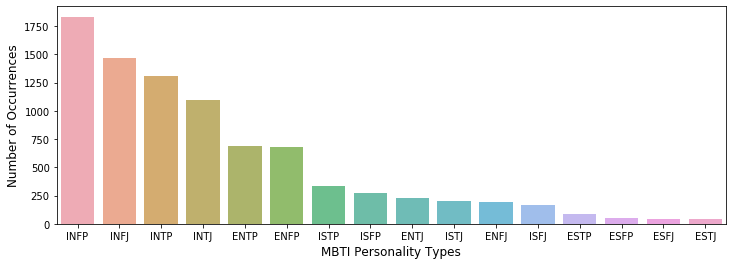

In [3]:
# Print distribution of MBTI personality types
cnt_types = df['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('MBTI Personality Types', fontsize=12)
plt.show()

In [4]:
# Re-classify dataset as 4 binary classifiers
df['is_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['is_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['is_T'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['is_J'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

print(df.head)

<bound method NDFrame.head of       type                                              posts  is_E  is_S  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...     0     0   
1     ENTP  'I'm finding the lack of me in these posts ver...     1     0   
2     INTP  'Good one  _____   https://www.youtube.com/wat...     0     0   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...     0     0   
4     ENTJ  'You're fired.|||That's another silly misconce...     1     0   
5     INTJ  '18/37 @.@|||Science  is not perfect. No scien...     0     0   
6     INFJ  'No, I can't draw on my own nails (haha). Thos...     0     0   
7     INTJ  'I tend to build up a collection of things on ...     0     0   
8     INFJ  I'm not sure, that's a good question. The dist...     0     0   
9     INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...     0     0   
10    INFJ  'One time my parents were fighting over my dad...     0     0   
11    ENFJ  'https://www.youtube.com/watch?v=P

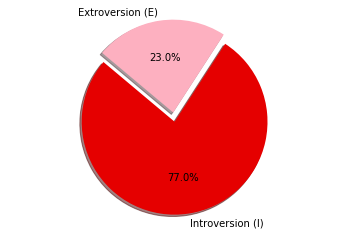

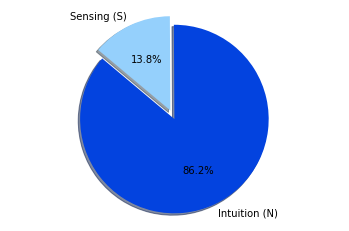

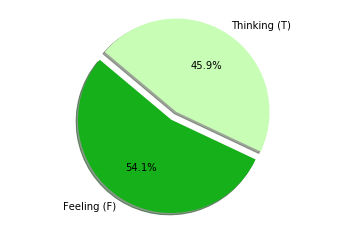

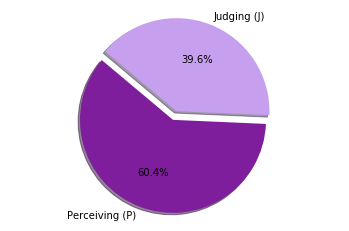

In [5]:
# Visualize I, E classifiers
labels = 'Introversion (I)', 'Extroversion (E)'
sizes = [8675 - np.count_nonzero(df['is_E']), np.count_nonzero(df['is_E'])]
colors = sns.xkcd_palette(['red', 'soft pink'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Visualize N, S classifiers
labels = 'Intuition (N)', 'Sensing (S)'
sizes = [8675 - np.count_nonzero(df['is_S']), np.count_nonzero(df['is_S'])]
colors = sns.xkcd_palette(['blue', 'light blue'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Visualize F, T classifiers
labels = 'Feeling (F)', 'Thinking (T)'
sizes = [8675 - np.count_nonzero(df['is_T']), np.count_nonzero(df['is_T'])]
colors = sns.xkcd_palette(['green', 'pale green'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Visualize P, J classifiers
labels = 'Perceiving (P)', 'Judging (J)'
sizes = [8675 - np.count_nonzero(df['is_J']), np.count_nonzero(df['is_J'])]
colors = sns.xkcd_palette(['purple', 'lavender'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Preprocessing

In [6]:
# Function to clean text data
def cleaner(text):
    stemmer = PorterStemmer()                                       
    text = text.replace('|||', ' ')
    text = re.sub(r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))      
    text = text.lower().strip()                                      
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

# Function to clean text data
def cleaner_rnn(text, stop):
    stemmer = PorterStemmer()                                       
    text = text.replace('|||', ' ')
    text = re.sub(r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))      
    text = text.lower().strip()                                      
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [7]:
df_working = df.copy()

# Convert to binary classifiers
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,is_E,is_S,is_T,is_J,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1,Introversion,Intuition,Feeling,Judging
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0,Extroversion,Intuition,Thinking,Perceiving
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0,Introversion,Intuition,Thinking,Perceiving
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1,Introversion,Intuition,Thinking,Judging
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1,Extroversion,Intuition,Thinking,Judging


In [8]:
# Create stopwords list including 16 MBTI types to avoid biasing the model
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']

stop = stopwords.words('english')

for type in types:
    stop.append(type)

stop_rev = stop    
print(stop_rev)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
# Run a final CountVectorizer on posts to include cleaning preprocessor arguments
posts = df_working['posts'].copy()
cv = CountVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit_transform(posts)

cv.transform(posts).todense()
df_posts = pd.DataFrame(cv.transform(posts).todense(), columns=cv.get_feature_names())

df_posts.head()

print(df_posts.sum().sort_values(ascending=False).head(10)) # Print top 10 words in posts

im        79995
like      75765
think     58275
dont      52778
peopl     47904
one       39656
know      39430
get       38870
feel      37014
realli    35223
dtype: int64


# Classification

In [10]:
# Train-test split, using type variable as target and posts variable as predictor
xTrain, xTest, yTrain, yTest = train_test_split(df_posts, df['type'].values, test_size = 0.20, random_state = 42)

print('X Train:', xTrain.shape, '   ', 'X Test:', xTest.shape, '   ', 'Y Train:', yTrain.shape, '   ', 'Y Test:', yTest.shape)

X Train: (6940, 1000)     X Test: (1735, 1000)     Y Train: (6940,)     Y Test: (1735,)


Text(0, 0.5, 'Explained Variance Ratio')

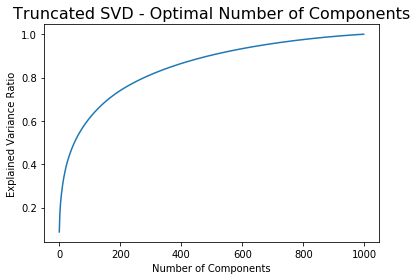

In [11]:
# Run Truncated SVD

# First use max components and graph the explained variance ratio to find cutoff point
tsvd = TruncatedSVD(n_components = 999)
tsvd.fit(xTrain)

plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title('Truncated SVD - Optimal Number of Components', fontsize = 16)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

In [12]:
# Run a Truncated SVD with 175 components
tsvd = TruncatedSVD(n_components = 175)
tsvd.fit(xTrain)

xTrain_tsvd = tsvd.transform(xTrain)
xTest_tsvd = tsvd.transform(xTest)

## Random Forest Classifier

In [13]:
# Parameters: 30 estimators, min 50 samples per leaf node, out-of-bag samples to estimate generalization accuracy
rfc = RandomForestClassifier(n_estimators = 30, min_samples_leaf = 50, oob_score = True, n_jobs = -1, random_state = 123)
rfc.fit(xTrain_tsvd, yTrain)

print('TRAINING SET')
print('Accuracy:', rfc.score(xTrain_tsvd, yTrain))
print('Confusion Matrix:')
print(confusion_matrix(yTrain, rfc.predict(xTrain_tsvd)))
print('Classification Report')
print(classification_report(yTrain, rfc.predict(xTrain_tsvd)))

print()
print('TEST SET')
print('Accuracy:', rfc.score(xTest_tsvd, yTest))
print('Confusion Matrix:')
print(confusion_matrix(yTest, rfc.predict(xTest_tsvd)))
print('Classification Report')
print(classification_report(yTest, rfc.predict(xTest_tsvd)))

TRAINING SET
Accuracy: 0.4175792507204611
Confusion Matrix:
[[   0    0    0    0    0    0    0    0   27  109    4    9    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   91  412    8   39    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   30   83   26   48    0    0
     0    0]
 [   0    0    0    1    0    0    0    0   60  304   50  135    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   10   23    1    1    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    7   24    1    8    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    5   14    8    5    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    8   41    6   19    0    0
     0    0]
 [   0    0    0    0    0    0    0    0  577  539   17   49    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   21 1405   11   25    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   84  358  331  125    0    0
     0    0]
 [   

## KNeighbors Classifier

Text(0.5, 0, 'K')

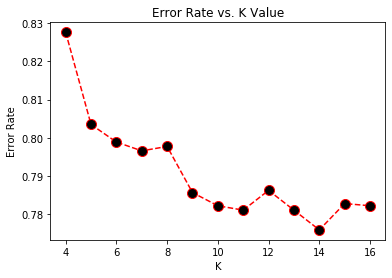

In [14]:
# Search for the optimal number of neighbors to use
error_rate = []

for i in range(4, 17):
    knn_lc = KNeighborsClassifier(n_neighbors = i)
    knn_lc.fit(xTrain_tsvd, yTrain)

    pred_i = knn_lc.predict(xTest_tsvd)
    error_rate.append(np.mean(pred_i != yTest))

plt.plot(range(4, 17), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'black', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.ylabel('Error Rate')
plt.xlabel('K')

In [15]:
k_dict = {'n_neighbors' : [7, 9, 11, 13],
          'weights' : ['uniform', 'distance'],
          'p' : [1, 2]}                        

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, k_dict, verbose = 2, n_jobs = -1)
gs.fit(xTrain_tsvd, yTrain)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [7, 9, 11, 13], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [16]:
print('Best score:', gs.best_score_)
print('Best parameters:', gs.best_params_)

Best score: 0.22780979827089337
Best parameters: {'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}


In [17]:
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'distance')
knn.fit(xTrain_tsvd, yTrain)

print('TRAINING SET')
print('Accuracy:', knn.score(xTrain_tsvd, yTrain))
print('Confusion Matrix:')
print(confusion_matrix(yTrain, knn.predict(xTrain_tsvd)))
print('Classification Report:')
print(classification_report(yTrain, knn.predict(xTrain_tsvd)))

print()
print('TEST SET')
print('Accuracy:', knn.score(xTest_tsvd, yTest))
print('Confusion Matrix:')
print(confusion_matrix(yTest, knn.predict(xTest_tsvd)))
print('Classification Report:')
print(classification_report(yTest, knn.predict(xTest_tsvd)))

TRAINING SET
Accuracy: 1.0
Confusion Matrix:
[[ 149    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0  550    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  187    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  550    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0   35    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0   40    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   32    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0   74    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0 1182    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0 1462    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0  898    0    0    0
     0    0]
 [   0    0    0    

In [18]:
df_rnn = df.copy()
df_rnn['cleanPosts'] = df_rnn.apply(lambda row: cleaner_rnn(row['posts'], stop_rev), axis = 1)

df_rnn.head()

,type,posts,is_E,is_S,is_T,is_J,cleanPosts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1,url url moment url sportscent top ten play url...
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0,im find lack post alarm sex bore posit often e...
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0,good one url cours say know that bless curs ab...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1,dear enjoy convers day esoter gab natur univer...
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1,your fire that anoth silli misconcept approach...


In [19]:
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_rnn['cleanPosts'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 116324 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df_rnn['cleanPosts'].values)
X = pad_sequences(X, maxlen=250)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (8675, 250)


In [21]:
Y = pd.get_dummies(df['type']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8675, 16)


In [22]:
xTrain_rnn, xTest_rnn, yTrain_rnn, yTest_rnn = train_test_split(X, Y, test_size=0.20, random_state=42)

print(xTrain_rnn.shape, yTrain_rnn.shape)
print(xTest_rnn.shape, yTest_rnn.shape)

(6940, 250) (6940, 16)
(1735, 250) (1735, 16)


In [23]:
model = Sequential()
model.add(Embedding(50000, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(xTrain_rnn, yTrain_rnn, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.00001)])

Epoch 1/5
87/87 [==============================] - 70s 808ms/step - loss: 2.3662 - accuracy: 0.1978 - val_loss: 2.2872 - val_accuracy: 0.2197
Epoch 2/5
87/87 [==============================] - 61s 699ms/step - loss: 2.2741 - accuracy: 0.2073 - val_loss: 2.2812 - val_accuracy: 0.2219
Epoch 3/5
87/87 [==============================] - 61s 704ms/step - loss: 2.1530 - accuracy: 0.2952 - val_loss: 2.3717 - val_accuracy: 0.1974
Epoch 4/5
87/87 [==============================] - 68s 778ms/step - loss: 1.7370 - accuracy: 0.4688 - val_loss: 2.6116 - val_accuracy: 0.1945
Epoch 5/5
87/87 [==============================] - 63s 724ms/step - loss: 1.3076 - accuracy: 0.6021 - val_loss: 2.8522 - val_accuracy: 0.1938


In [24]:
accr = model.evaluate(xTest_rnn, yTest_rnn)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

55/55 [==============================] - 4s 75ms/step - loss: 2.8777 - accuracy: 0.1833
Test set
  Loss: 2.878
  Accuracy: 0.183


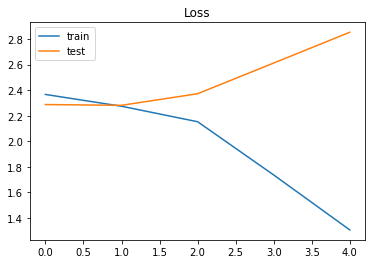

In [25]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

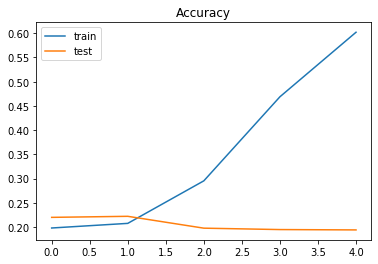

In [26]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [27]:
new_post = ['Hey,  I’m not looking for social contacts. I have friends. I’m fine.']
seq = tokenizer.texts_to_sequences(new_post)
padded = pad_sequences(seq, maxlen=500)
pred = model.predict(padded)
labels = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
print(pred, labels[np.argmax(pred)])

[[3.4412468e-04 6.5872492e-03 1.0696261e-04 2.1072535e-03 2.3341135e-04
  7.4679483e-05 1.3486788e-04 1.9411086e-04 2.0536790e-03 9.1486138e-01
  6.9537869e-04 6.4044148e-02 2.9949239e-04 2.3539506e-03 1.2905624e-04
  5.7803593e-03]] istp
